In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [58]:
def plot_decision_region_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    Y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[Y[:] == 0, 0], X[Y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[Y[:] == 1, 0], X[Y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[Y[:] == 2, 0], X[Y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [ ]:
class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

In [115]:
class Net(nn.Module):
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L-1:
                activation = torch.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
               
        return activation
        

In [116]:
def train(data_set, model, criterion, train_loader, optimizer, epochs = 100):
    LOSS = []
    ACC = []
    
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            
            loss = criterion(yhat, y)
            loss.backward()
            
            optimizer.step()
            
            LOSS.append(loss.data.item())
            
        ACC.append(accuracy(model, data_set))
        
        
        if (epoch % 10 == 0):
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {LOSS[-1]:.4f} - Accuracy: {ACC[-1]*100:.2f}%")

        
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return LOSS

In [117]:
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    
    return (yhat == data_set.y).numpy().mean()

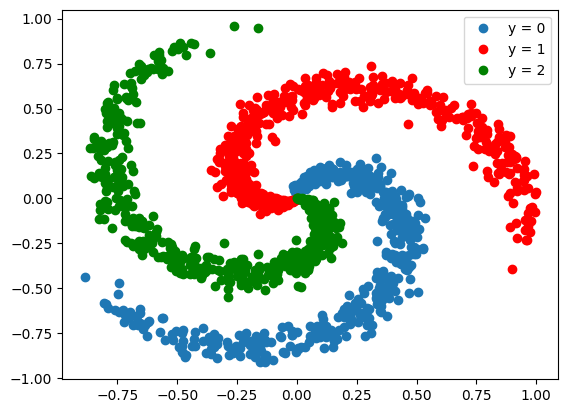

In [118]:
data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

Epoch [1/500] - Loss: 0.9204 - Accuracy: 33.33%
Epoch [11/500] - Loss: 0.5936 - Accuracy: 49.73%
Epoch [21/500] - Loss: 0.5136 - Accuracy: 59.40%
Epoch [31/500] - Loss: 0.5128 - Accuracy: 61.93%
Epoch [41/500] - Loss: 0.5497 - Accuracy: 63.73%
Epoch [51/500] - Loss: 0.5538 - Accuracy: 65.00%
Epoch [61/500] - Loss: 0.5256 - Accuracy: 66.53%
Epoch [71/500] - Loss: 0.4792 - Accuracy: 68.07%
Epoch [81/500] - Loss: 0.4231 - Accuracy: 70.73%
Epoch [91/500] - Loss: 0.3628 - Accuracy: 73.27%
Epoch [101/500] - Loss: 0.3062 - Accuracy: 75.67%
Epoch [111/500] - Loss: 0.2557 - Accuracy: 78.20%
Epoch [121/500] - Loss: 0.2141 - Accuracy: 80.67%
Epoch [131/500] - Loss: 0.1790 - Accuracy: 82.87%
Epoch [141/500] - Loss: 0.1524 - Accuracy: 84.60%
Epoch [151/500] - Loss: 0.1323 - Accuracy: 86.47%
Epoch [161/500] - Loss: 0.1147 - Accuracy: 87.33%
Epoch [171/500] - Loss: 0.1019 - Accuracy: 88.20%
Epoch [181/500] - Loss: 0.0909 - Accuracy: 89.33%
Epoch [191/500] - Loss: 0.0811 - Accuracy: 90.20%
Epoch [201/

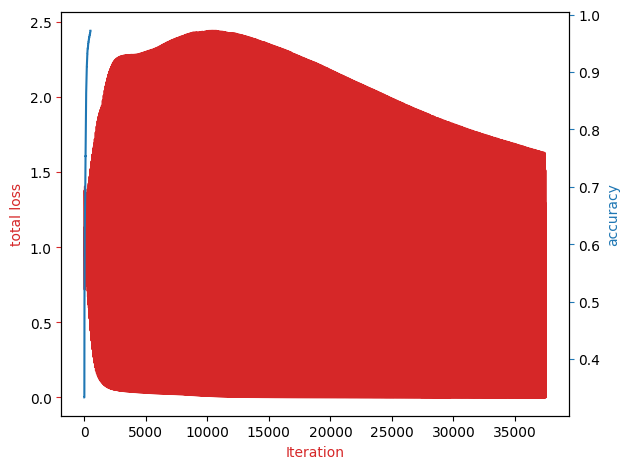

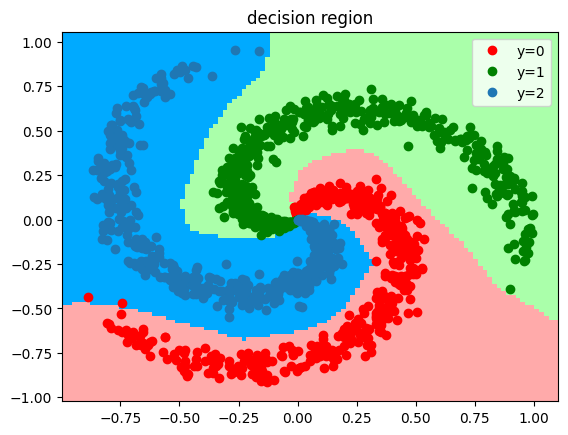

In [119]:
Layers = [2, 50, 50, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 500)
plot_decision_region_3class(model, data_set)